In [0]:
# author: Lu Yu
# version: 07/31/19

# Reservoir Computing (RC) RNN

This notebook follows some of the contents and structures of the post from [Matthew Stewart](https://towardsdatascience.com/predicting-stock-prices-with-echo-state-networks-f910809d23d4). Based on [his work](https://github.com/mrdragonbear/EchoStateNetworks), we added the way to evaluate the model performance, such as precision, recall, accuracy, and MSE. 

We used a simple and self-contained version of Echo State Networks implementation called [pyESN](https://github.com/cknd/pyESN).

 This is how the model is set up:
 
 **You call the RC as:**
esn = ESN(n_inputs = 1, <br>
 $\quad$ $\quad$     n_outputs = #, <br>
 $\quad$ $\quad$     n_reservoir = #,<br>
 $\quad$ $\quad$     sparsity= #,<br>
 $\quad$ $\quad$     random_state= #, <br>
 $\quad$ $\quad$     spectral_radius = #,<br>
 $\quad$ $\quad$     noise= #)
<br> where # denotes the value that you choose.

**Brief explanation of the parameters:**
n_inputs: number of input dimensions <br>
n_outputs: numberr of output dimensions <br>
n_reservoir: number of reservoir neurons <br> 
random_state: seed for the random generator<br>
sparsity: proportion of recurrent weights set to zero <br>
spectral_radius: spectral radius of the recurrent weight matrix <br>
noise: noise added to each neuron (regularization) <br>

## Setup

### Import packages

You need to upload the file `pyESN.py` in order to use the model. The file is in the `model/bin` folder.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc
import warnings
# from sklearn.metrics import mean_squared_error
rc('text', usetex=False)
warnings.filterwarnings('ignore')

# This is the library for the Reservoir Computing got it by: https://github.com/cknd/pyESN
from google.colab import files
src = list(files.upload().values())[0]
open('pyESN.py','wb').write(src)
from pyESN import ESN 
%matplotlib inline

Saving pyESN.py to pyESN.py


Next, upload the dataset `bitcoin_merged.xlsx` to Google Colab, or 

use the file path `../../bitcoin/data/bitcoin_data/bitcoin_merged.xlsx` if you are running this file using Jupyter Notebook.

We will only feed the Bitcoin Core price to the model.

### Import data

You can upload `bitcoin_merged.xlsx` to the Colab. The file is in the `bitcoin/bitcoin_data` folder.

In [0]:
data = pd.read_excel('./bitcoin_merged.xlsx')
data = data[['Bitcoin Core (BTC) Price']]
data = np.array(data).astype('float64')

Since the Bitcoin price flutuate a lot, the result would be more accurate if the input data is scaled. Here we use `MinMaxScaler`.

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

### Model setup

Use the ESN from the pyESN library to employ an RC network. The task here is to predict two time points ahead by using the previous 1500 points and do that for 100 future points. So, in the end you will have a 100 time step prediction with prediction_window = 2. This will be your test set.

In [0]:
def init_model(n_reservoir, sparsity, rand_seed, spectral_radius, noise): 
  esn = ESN(n_inputs = 1,
        n_outputs = 1, 
        n_reservoir = n_reservoir,
        sparsity=sparsity,
        random_state=rand_seed,
        spectral_radius = spectral_radius,
        noise=noise)
  return esn

In [0]:
def run_model(esn, data, trainlen, future, futureTotal): 
  trainlen = trainlen # use this amount of price data to train the model
  future = future # predict two-day prices at one time
  futureTotal = futureTotal # predict the next 100-day prices
  pred_tot = np.zeros(futureTotal) # space for predicted price
  start = data.shape[0] - trainlen - futureTotal # set the starting of the window

  for i in range(0, futureTotal, future):
      pred_training = esn.fit(np.ones(trainlen),data[start+i:start+trainlen+i])
#       print("Training from " + str(start+i) + " to " + str(start+trainlen+i))
      prediction = esn.predict(np.ones(future))
      pred_tot[i:i+future] = prediction[:,0]
  return start, pred_tot

### Model prediction

Plot the prediction along with the actual data for the training and for the test dataset

In [0]:
def plot_model(data, pred_tot, start, trainlen):
  plt.figure(figsize=(16,8))
  plt.plot(range(start,data.shape[0]),data[start:],'b',label="Data", alpha=0.3)
  plt.plot(range(start+trainlen,data.shape[0]),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

  lo,hi = plt.ylim()
  plt.plot([start+trainlen,start+trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

  plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
  plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
  plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
  plt.legend(fontsize='xx-large', loc='best')
  sns.despine()

### Evaluate performance

Calculate the percentage of change for the actual data and the predicted data.

Use two lists to keep track of the price changes. For each entry:

* 1 if the price increases
* 0 if the price decreases

Next, we calculate the true positive, false positive, true negative, and false negative. 

Recall that, 

A **true positive** is an outcome where the model correctly predicts the positive class. 

Similarly, a **true negative** is an outcome where the model correctly predicts the negative class.

A **false positive** is an outcome where the model incorrectly predicts the positive class. 

And a **false negative** is an outcome where the model incorrectly predicts the negative class.

*Source:* https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative

Last, we could use the results above to find the precision, recall, and F1 score. Recall that,

**Precision** attempts to answer the following question:

> What proportion of positive identifications was actually correct?

**Recall** attempts to answer the following question:

> What proportion of actual positives was identified correctly?

**Accuracy** is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. 

*Source: * https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

https://developers.google.com/machine-learning/crash-course/classification/accuracy

In [0]:
def eval_model(data, pred_tot, start, trainlen):
  # 1. calculate percentage of change for actual data and predicted data
  y_test = data[start+trainlen:]

  y_test_today = data[start+trainlen+1:]
  y_test_prev = data[start+trainlen:-1]

  y_pred_today = pred_tot[1:]
  y_pred_prev = pred_tot[:-1]

  delta_predict = (y_pred_today - y_pred_prev) / (y_pred_prev)
  delta_test = (y_test_today - y_test_prev) / (y_test_prev)

  # 2. mark whether the price goes up or down
  delta_pred = np.empty(delta_predict.shape)
  delta_real = np.empty(delta_test.shape)
  
  for i in range(delta_predict.shape[0]):
      if delta_predict[i] > 0:
          delta_pred[i] = 1
      else:
          delta_pred[i] = 0
  for i in range(delta_test.shape[0]):
      if delta_test[i] > 0:
          delta_real[i] = 1
      else:
          delta_real[i] = 0    
          
  # 3. calculate TP, TN, FP, FN      
  true_pos = 0
  false_pos = 0
  true_neg = 0
  false_neg = 0
  for i in range(delta_real.shape[0]):
      real = delta_real[i]
      predicted = delta_pred[i]
      if real == 1:
          if predicted == 1:
              true_pos += 1
          else:
              false_neg += 1
      elif real == 0:
          if predicted == 0:
              true_neg += 1
          else:
              false_pos += 1
              
  # 4. calculate precision, recall, F1, accuracy, and MSE
  precision = float(true_pos) / (true_pos + false_pos)
  recall = float(true_pos) / (true_pos + false_neg)
  F1 = float(2 * precision * recall) / (precision + recall)
  accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)
  MSE = np.sqrt(np.mean((pred_tot.flatten() - y_test)**2))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  print("F1 score: " + str(F1))
  print("Accuracy: " + str(accuracy))
  print("MSE: " + str(MSE))

## Put together

Based on the previous tries, the following hyper-parameters gives a relative good performance:

- n_reservoir = 500
- sparsity=0.2
- random_state=23
- spectral_radius=1.5
- noise = 0.1

In [0]:
n_reservoir = 500
sparsity = 0.2
random_state = 23
spectral_radius = 1.5
noise = 0.1

trainlen = 1500
future = 2
futureTotal = 100

In [0]:
model = init_model(n_reservoir, sparsity, random_state, spectral_radius, noise)

In [0]:
start, pred_tot = run_model(model, data, trainlen, future, futureTotal)

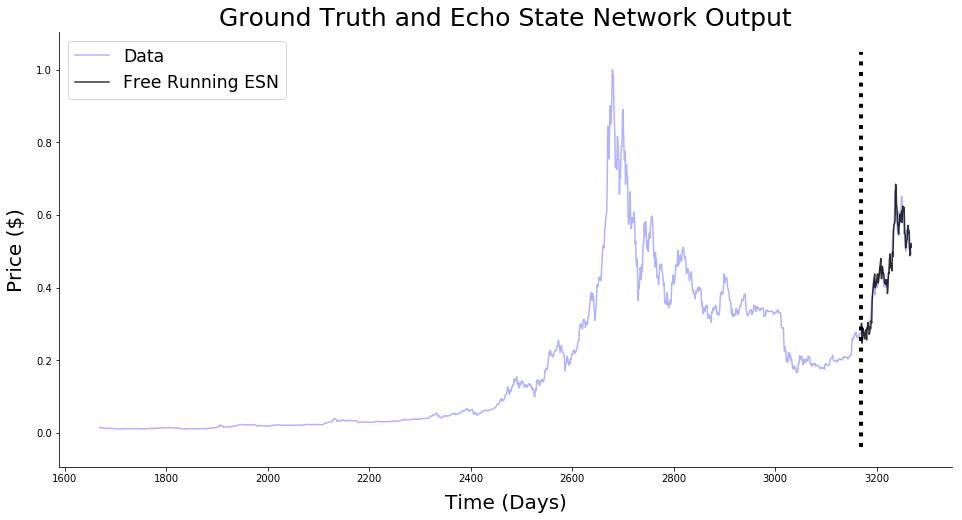

In [92]:
plot_model(data, pred_tot, start, trainlen)

In [93]:
eval_model(data, pred_tot, start, 1500)

Precision: 0.6607142857142857
Recall: 0.6491228070175439
F1 score: 0.6548672566371682
Accuracy: 0.6060606060606061
MSE: 0.158374384152533


## Find optimal set of parameters (Optional)

### Radius and noise

Fixing `reservoir=500` and `sparsity=0.2`, we set some possible values of radius and noise and see which combination gives us the best performance.

In [0]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

In [78]:
n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]


radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 1500
future = 2
futureTotal= 100
# start = data.shape[0] - trainlen - futureTotal -1

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]
        model = init_model(n_reservoir, sparsity, rand_seed, rho, noise)
        start, pred_tot = run_model(model, data, trainlen, future, futureTotal)

        loss[l, j] = MSE(pred_tot, data[start+trainlen:])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )


rho =  0.5 , noise =  0.0001 , MSE =  0.1564661727812207
rho =  0.5 , noise =  0.0003 , MSE =  0.15693097595529298
rho =  0.5 , noise =  0.0007 , MSE =  0.15713091638650056
rho =  0.5 , noise =  0.001 , MSE =  0.15720146363975054
rho =  0.5 , noise =  0.003 , MSE =  0.15732572148133903
rho =  0.5 , noise =  0.005 , MSE =  0.15716773351214355
rho =  0.5 , noise =  0.007 , MSE =  0.1570019529912707
rho =  0.5 , noise =  0.01 , MSE =  0.15680573135585313
rho =  0.7 , noise =  0.0001 , MSE =  0.15697224989195216
rho =  0.7 , noise =  0.0003 , MSE =  0.15621846433085665
rho =  0.7 , noise =  0.0007 , MSE =  0.15626542416806596
rho =  0.7 , noise =  0.001 , MSE =  0.15650974634433348
rho =  0.7 , noise =  0.003 , MSE =  0.1572242544043792
rho =  0.7 , noise =  0.005 , MSE =  0.15733701746933895
rho =  0.7 , noise =  0.007 , MSE =  0.15731193975615393
rho =  0.7 , noise =  0.01 , MSE =  0.15719934646738049
rho =  0.9 , noise =  0.0001 , MSE =  0.15807751455197322
rho =  0.9 , noise =  0.0003 

A visualization to show the MSE for the different values of `spectral_radius` and `noise`.

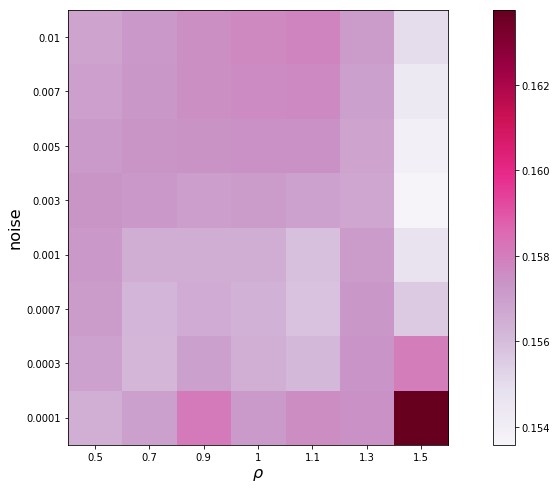

In [79]:
plt.figure(figsize=(16,8))
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuRd')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 

# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 

In [80]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.5 
noise =  0.003 
MSE =  0.1535803761583225


From the performance of several possible combinations above, we notice that when `spectrum radius` is 1.5 and `noise` is 0.003, we have the lowest MSE.

### Reservoir and sparsity

Based on the best combination of radius and noise, we may also find the potential good candidiates of reservoir and sparsity.

In [81]:
n_reservoir_set = [100, 200, 300, 400, 500]
sparsity_set    = [0.01, 0.05, 0.1, 0.2, 0.5]
rand_seed       = 23

radius = 1.5
noise = 0.003


n_reservoir_size  = len(n_reservoir_set)
sparsity_size = len(sparsity_set)

trainlen = 1500
future = 2
futureTotal= 100
start = data.shape[0] - trainlen - futureTotal -1

loss = np.zeros([n_reservoir_size, sparsity_size])

for l in range(n_reservoir_size):
    n_reservoir = n_reservoir_set[l]
    for j in range(sparsity_size):
        sparsity = sparsity_set[j]
        
        model = init_model(n_reservoir, sparsity, rand_seed, rho, noise)
        start, pred_tot = run_model(model, data, trainlen, future, futureTotal)
        
        loss[l, j] = MSE(pred_tot, data[start+trainlen:start+trainlen+futureTotal])        
        print('reservoir = ', n_reservoir_set[l], ', sparsity = ', sparsity_set[j], ', MSE = ', loss[l][j] )


reservoir =  100 , sparsity =  0.01 , MSE =  0.15795988694816934
reservoir =  100 , sparsity =  0.05 , MSE =  0.15697394952848548
reservoir =  100 , sparsity =  0.1 , MSE =  0.16026206965519785
reservoir =  100 , sparsity =  0.2 , MSE =  0.15976459975796553
reservoir =  100 , sparsity =  0.5 , MSE =  0.15873694575109207
reservoir =  200 , sparsity =  0.01 , MSE =  0.15791177583097007
reservoir =  200 , sparsity =  0.05 , MSE =  0.1587186422112982
reservoir =  200 , sparsity =  0.1 , MSE =  0.15631799313244737
reservoir =  200 , sparsity =  0.2 , MSE =  0.15710557693554586
reservoir =  200 , sparsity =  0.5 , MSE =  0.15882011409267552
reservoir =  300 , sparsity =  0.01 , MSE =  0.15771700498469224
reservoir =  300 , sparsity =  0.05 , MSE =  0.15789103392386178
reservoir =  300 , sparsity =  0.1 , MSE =  0.15795636000131222
reservoir =  300 , sparsity =  0.2 , MSE =  0.15813858975695008
reservoir =  300 , sparsity =  0.5 , MSE =  0.155196442189187
reservoir =  400 , sparsity =  0.01 ,

A visualization to show the MSE for the different values of `n_reservoir` and `sparsity`.

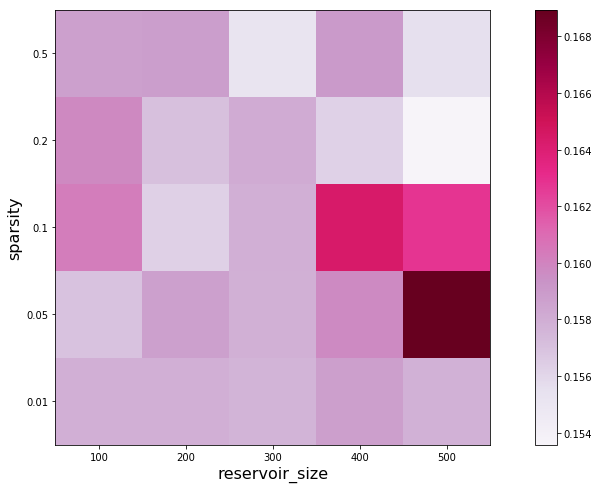

In [82]:
plt.figure(figsize=(16,8))
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuRd')
plt.xticks(np.linspace(0,n_reservoir_size-1,n_reservoir_size), n_reservoir_set);
plt.yticks(np.linspace(0,sparsity_size-1, sparsity_size), sparsity_set);
plt.xlabel(r'reservoir_size', fontsize=16); plt.ylabel('sparsity', fontsize=16); 

# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 

In [83]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
reservoir_opt = n_reservoir_set[int(index_min[0])]
sparsity_opt = sparsity_set[int(index_min[1])]
print('The optimal set is:\nspectrum reservoir = ',
      reservoir_opt,'\nsparsity = ',sparsity_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum reservoir =  500 
sparsity =  0.2 
MSE =  0.1535803761583225


The optimal set is still the combination of `spectrum reservoir =  500` and `sparsity =  0.2`, given that `radius = 1.5` and `noise = 0.003`.